In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed_data/feature_engineered.csv')
df

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,1,-455,1,11.77,11.770000,0.00,0.0
1,2,-444,2,89.00,44.500000,0.00,0.0
2,3,-127,5,139.47,27.894000,16.99,1.0
3,4,-110,4,100.50,25.125000,0.00,0.0
4,5,-88,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...
23565,23566,-372,1,36.00,36.000000,0.00,0.0
23566,23567,-372,1,20.97,20.970000,0.00,0.0
23567,23568,-344,3,121.70,40.566667,0.00,0.0
23568,23569,-372,1,25.74,25.740000,0.00,0.0


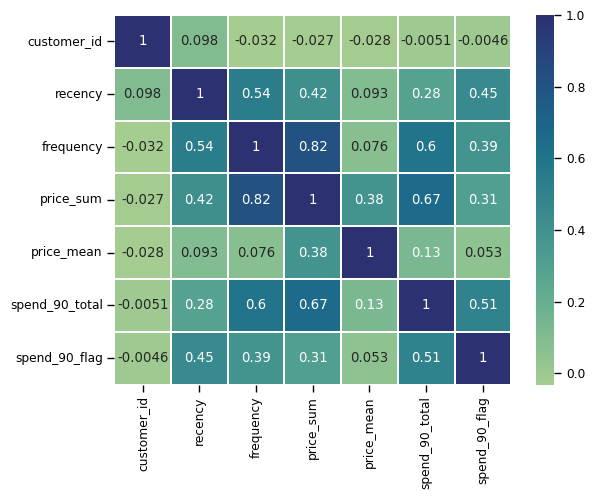

In [43]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.3, cmap='crest')
plt.show()

In [4]:
X = df[['recency', 'frequency', 'price_sum', 'price_mean']]
y = df['spend_90_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

param_grid = {
  'n_estimators': [100, 200, 300],
  'max_depth': [3, 5, 7],
  'learning_rate': [0.01, 0.1, 0.2],
  'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(
  estimator=xgb,
  param_grid=param_grid,
  scoring='roc_auc',
  cv=5,
  n_jobs=-1
)
grid_search.fit(X_train, y_train)

probability_model = grid_search.best_estimator_
y_pred = probability_model.predict_proba(X_test)

In [6]:
grid_search.best_score_

0.8408885097278208

In [8]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

In [9]:
y_pred

array([[0.6600778 , 0.3399222 ],
       [0.7770165 , 0.22298345],
       [0.7963128 , 0.20368716],
       ...,
       [0.656054  , 0.34394598],
       [0.7778598 , 0.22214021],
       [0.7984527 , 0.20154734]], dtype=float32)

In [10]:
feature_imp_dict = probability_model.get_booster().get_score(importance_type='gain')

In [11]:
feature_imp_df = pd.DataFrame(
  data={
    'feature': list(feature_imp_dict.keys()),
    'value': list(feature_imp_dict.values())
  }
)

In [12]:
feature_imp_df

,feature,value
0,recency,228.714218
1,frequency,87.461021
2,price_sum,6.812809
3,price_mean,3.937132


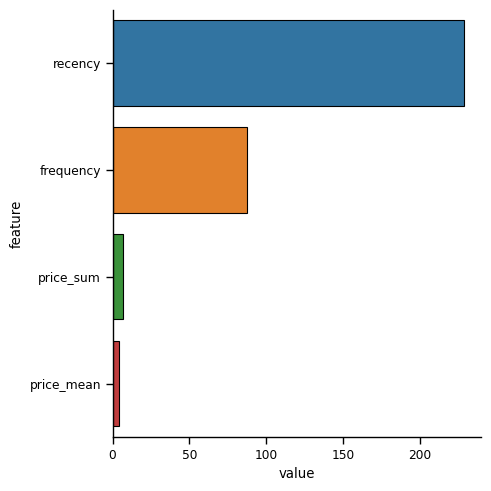

In [44]:
sns.catplot(data=feature_imp_df, x="value", y='feature', kind='bar', edgecolor='black')